In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# args is only used when f has additional arguments
# for the basic case, f = f(y,t) only.
# For the vectorial case, y0 should be a list. 
# If y0 is a list, y is matrix. If y0 is scalar, y is a vector 

def euler_exp(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0))) if type(y0) is list else np.zeros(n)
    y[0] = y0
    for i in range(n - 1):
        y[i+1] = y[i] + (t[i+1] - t[i]) * f(y[i], t[i], *args)
    
    return y

def rungekutta4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0))) if type(y0) is list else np.zeros(n)
    y[0] = y0
    for i in range(n - 1):
        h = t[i+1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2., t[i] + h / 2., *args)
        k3 = f(y[i] + k2 * h / 2., t[i] + h / 2., *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i+1] = y[i] + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4)
    return y


methods = { 'EE': euler_exp,
            'RK4': rungekutta4}


**2) Construction d'une solution exacte** 
Prenons par example $y(t) = \exp{t^2} \cos (t^3)$. On a donc $y(0) = 1$, cherchons $y'(t)$
\begin{align*}
y'(t) &= 2 t \exp{t^2} \cos{t^3} - 3t^2 \exp{t^2} \sin t^3 \\&= 2 t y(t) - 3t^2 y(t) \tan t^3 := f(t,y(t)) 
\end{align*} 
Pour bien tester les méthodes, c'est important de d'écrire la dépéndence en $y(t)$ explicitement sur $f$, de façon qu'on puisse tester la propagation d'erreurs dans chaque méthode.

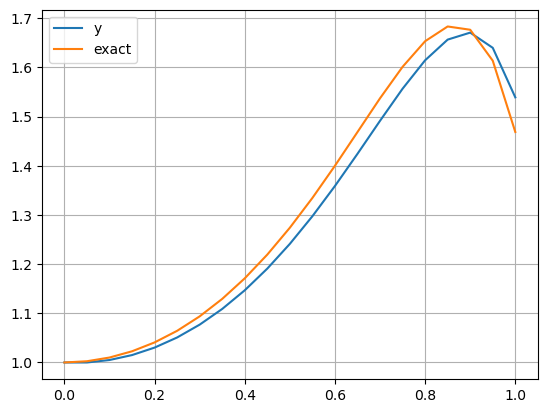

In [5]:
y_exact = lambda t: np.exp(t**2)*np.cos(t**3)
f = lambda y, t: 2*t*y - 3*t**2*y*np.tan(t**3)
y0 = 1.0

t_max = 1.0
N = 20
t = np.linspace(0,t_max,N+1)

y = euler_exp(f, y0, t, args = ())
# y = rungekutta4(f, [y0], t, args = ())

plt.plot(t, y, label = "y")
plt.plot(t, y_exact(t), label = 'exact')
plt.legend()
plt.grid()

**3) Calcul l'ordre de convergence**

L'erreur théorique pour un longueur characteristique de discretisation $h$ est donné par:
$$
e_h = \|y_h - y^*\| \leq C h^{\alpha}
$$
où $y^*$ est la solution exacte, $y_h$ la solution approché, $\alpha$ est l'ordre de convergence, $C$ une constant indépendamment de $h$ spécifique de chaque méthode. Pour la norme $\|\cdot \|$, plusieurs choixs sont possibles mais on regarde plus souvent la norme $L^2$ ($:= \sqrt{\int_{a}^b |f(t)|^2 dt}$), l'intégrale étant calculé par l'un des méthodes d'intégration numérique (trapèze ou simpson par exemple).

Pour trouver $\alpha$, on va se donner $h_1$ et $h_2$, tels que $h_1 > h_2>0$. En applicant la fonction logarithme des deux côtés de l'inégalité on a
$$
\log e_{h_1} \leq C + \alpha \log h_1, \\
\log e_{h_2} \leq C + \alpha \log h_2.
$$
En prénant la différence des ces deux inégalités, on trouve:
$$
\log (e_{h_1}/e_{h_2}) \leq \alpha \log (h_1/h_2)
$$
Comme $\frac{h_1}{h_2} := b>1$, la fonction logarithme est positive. On a donc 
$$
\alpha \geq \log (e_{h_1}/e_{h_2})/\log b = \log_b (e_{h_1}/e_{h_2})
$$
Dans la pratique, on se prend une facteur fixe $b=2$ ou $b=10$ pour le rafinement du intervale et on considère l'inégalité plutôt comme une égalité. L'estimation de l'ordre est valide pour des $h$ suffisament petits tel que la courbe log-log semble une droite (pour $h$ grand, très souvent il y a pas mal de variation dans l'ordre de convergence calculé numériquement). 

order EE : 1.0015472432588903
order RK4 : 4.018676386502557


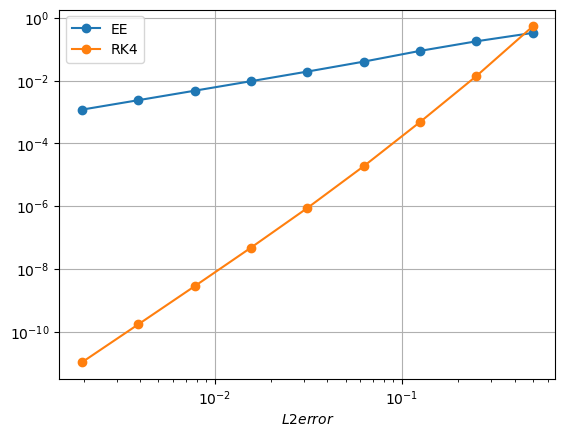

In [8]:
# np.trapz is the numpy's trapezoidal rule for integrals
L2norm = lambda x,t: np.sqrt(np.trapz(x**2,t)) 

# if N increases with the power of 2, h decreases by half in each increment. 
Nlist = np.array([2**i for i in range(1,10)]) 
hlist = t_max/Nlist

Iapp = {}
error = {key: [] for key in methods.keys()}
for N in Nlist:
    t = np.linspace(0., t_max, N)
    yex = y_exact(t)
    for m in methods.keys():
        ode_fun = methods[m]
        y_num = ode_fun(f, [y0], t)[:,0]
        error[m].append(L2norm(y_num-yex, t))

# order of convergence evaluated between the last two errors
for m in methods.keys():
    print("order {0} : {1}".format(m, np.log2(error[m][-2]/error[m][-1])))



plt.figure(2)
for m in methods.keys():
    plt.plot(hlist, error[m], '-o', label = m)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$h$')
plt.xlabel('$L2 error$')
plt.legend()
plt.grid()